In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from matplotlib import animation
from scipy import stats

import sys; sys.path.insert(1, '/saturn/simu_Caribbean/coupled_2km')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
from pdist_fb_distrib_save_fast import *
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'

wrf_files = path + 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [3]:
# open data - HOURLY
ds_hourly = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')
'''ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-02-29T22:30:00.000000000'))
del ds_tot'''
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values


In [14]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst = sst.groupby('time_counter.day').mean()

In [5]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')

In [15]:
sst_classic = sst.where(sea_mask, drop=False)
sst_modified = sst.where(sea_mask_modified, drop=False)

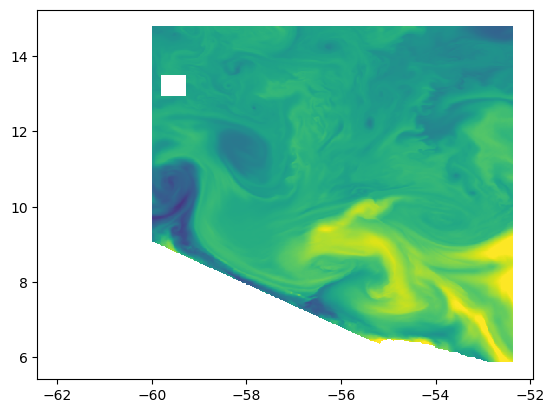

In [16]:
plt.pcolormesh(lon_M, lat_M, sst_modified[25]-273.15, vmin=25, vmax=27, cmap='viridis')

In [17]:
# compute anomalies daily data
s = 100


dsst_classic = np.zeros(sst_classic.values.shape)
dsst_modified = np.zeros(sst_modified.values.shape) 

for t in range(0,sst_classic.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave_cl = gm.nan_gaussian_filter(sst_classic[t],s)                          
    sst_ave_mo = gm.nan_gaussian_filter(sst_modified[t],s)
    
    dsst_classic[t] = sst_classic[t] - sst_ave_cl
    dsst_modified[t] = sst_modified[t] - sst_ave_mo
    

0
10
20


/venus/tesi_ale/img_EU/SST/comparison_dSST_oldMask_newMask.png


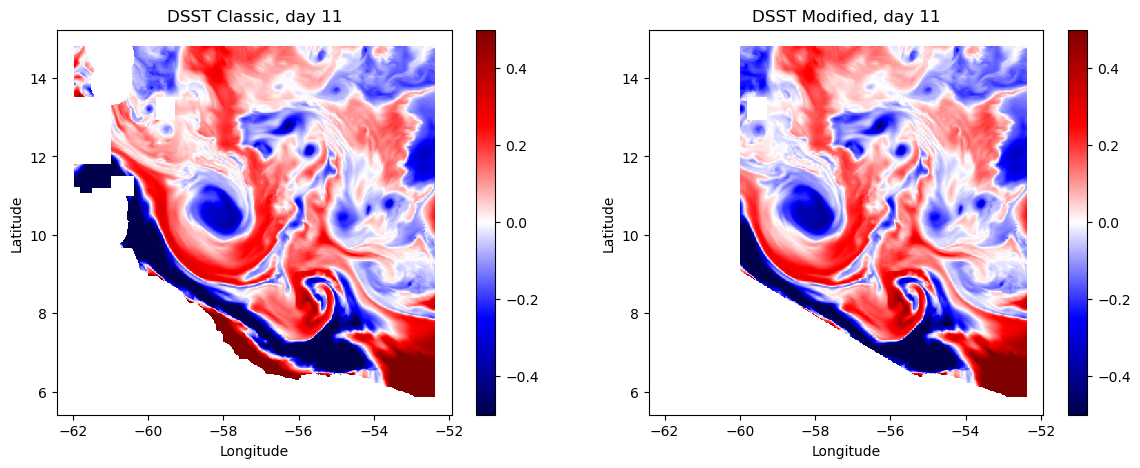

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

day = int(10)

# Plot dsst_classic
c1 = ax1.pcolormesh(lon_M, lat_M, dsst_classic[day], vmin=-0.5, vmax=0.5, cmap='seismic')
ax1.set_title(f'DSST Classic, day {day+1}')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(c1, ax=ax1, orientation='vertical')

# Plot dsst_modified
c2 = ax2.pcolormesh(lon_M, lat_M, dsst_modified[day], vmin=-0.5, vmax=0.5, cmap='seismic')
ax2.set_title(f'DSST Modified, day {day+1}')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
fig.colorbar(c2, ax=ax2, orientation='vertical')


path_img = '/venus/tesi_ale/img_EU/SST/' #if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'comparison_dSST_oldMask_newMask.png' #if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
plt.savefig(filename)
print(filename)
del filename

In [24]:
# lon   lat
# -55.5   6.5
# -59   8.5
xlon_index = np.argwhere((lon_M[0,:]>-59) & (lon_M[0,:]<-55.5))
xlon = lon_M[0,xlon_index]

m = (8.5-6.5)/(-59+55.5)

ylat = (xlon+55.5)*m+6.5

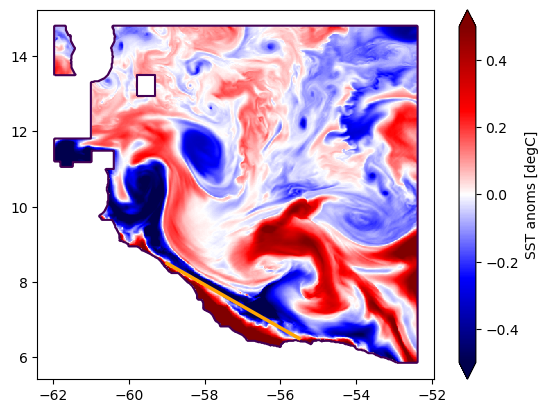

In [25]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask, levels=[0.])

plt.plot(xlon, ylat, 'orange', linewidth=2.5)

In [26]:
lat_line = (lon_M[0,:]+55.5)*m+6.5


for i in range(len(lat_M[0,:])):
    sea_mask[ lat_M[:,i]<lat_line[i],i ] = 0


In [30]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_noWarmPatch_noWest.npy', [sea_mask_alternative])

creating new file and saving variables


In [28]:
sea_mask_alternative = sea_mask
sea_mask_alternative[lon_M<-60]=0

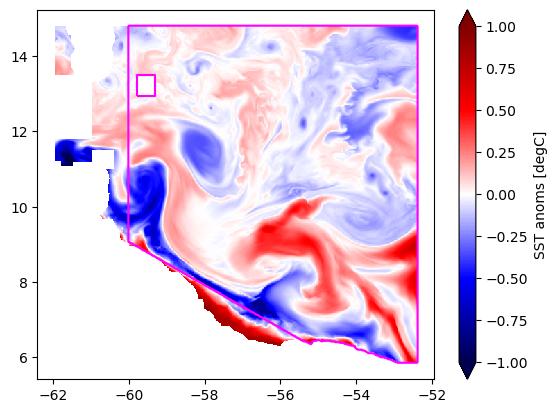

In [29]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-1, vmax=1, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask_alternative, levels=[0.], colors='magenta', linewidth=2.5)

In [ ]:
''''

warm_patches_index = np.argwhere(dsst_day>0.25)
warm_patches_values = dsst_day[warm_patches_index[:,0], warm_patches_index[:,1], warm_patches_index[:,2]]

day = int(25)

plt.pcolormesh(lon_M, lat_M, dsst_day[day,:,:], vmin=0.2, vmax=0.5, cmap='jet')
plt.colorbar(location='right', shrink=0.8, extend='both', label='SST anoms [degC]')  

cont = plt.contour(lon_M, lat_M, dsst_day[day,:,:], levels=[0.3, 0.5], cmap='YlOrRd')
plt.clabel(cont, inline=True, fontsize=10)

plt.xlabel('lon'); plt.ylabel('lat')
plt.title(f'Warmest dSST')'''

'

In [15]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

<IPython.core.display.Javascript object>


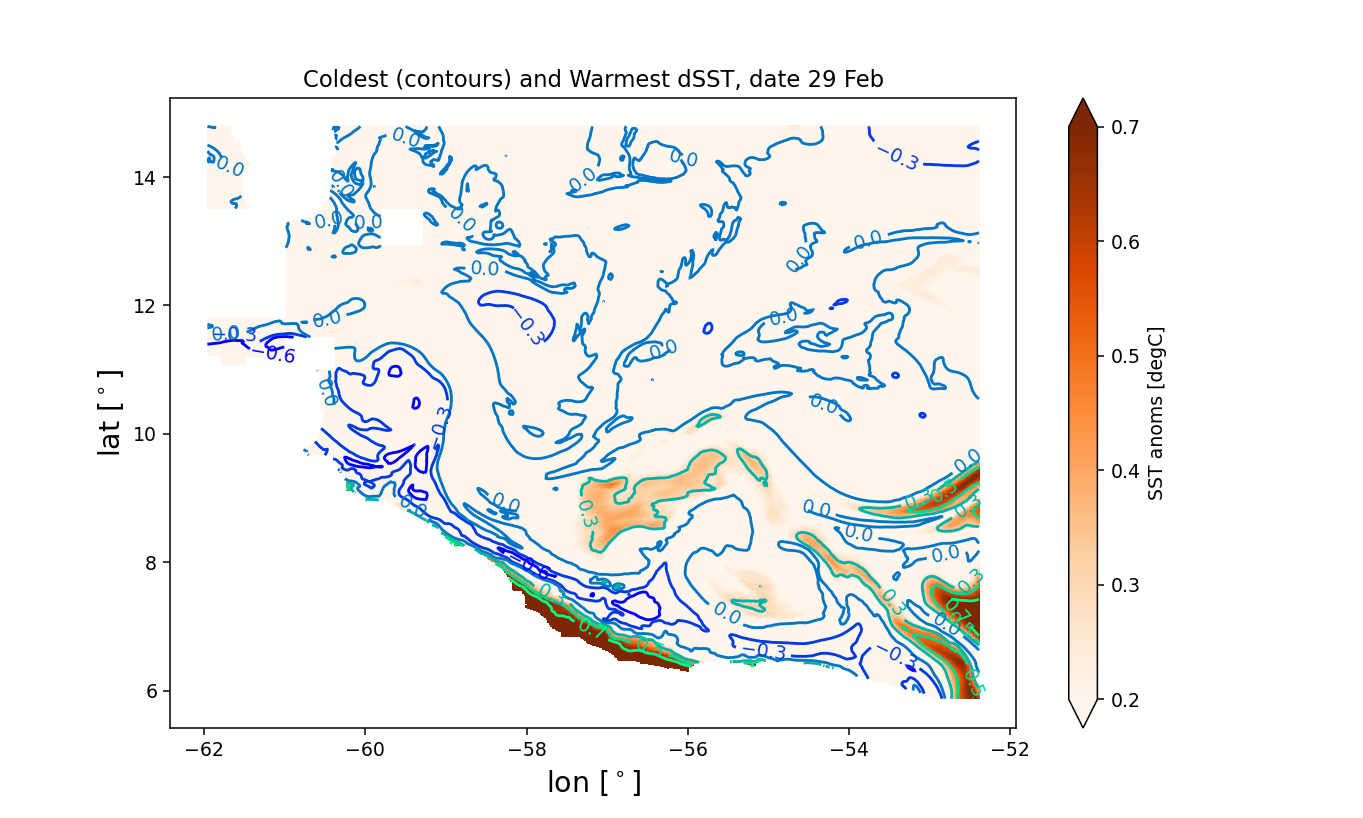

In [16]:
%matplotlib notebook

trange = 29                         #len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange))
levs = [-0.6, -0.3, 0., 0.3, 0.5, 0.7]
mindsst, maxdsst = 0.2, 0.7
cont_cmap = 'winter'
mesh_cmap = 'Oranges'

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon_M[0,0], lon_M[0,-1]), ylim=(lat_M[0,0], lat_M[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# set initial plot
contf = ax.pcolormesh(lon_M, lat_M, dsst_day[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
cbar = fig.colorbar(contf, extend='both')
cbar.set_label('SST anoms [degC]')

cont = ax.contour(lon_M, lat_M, dsst_day[0,:,:], levels=levs, cmap=cont_cmap)
ax.clabel(cont, inline=True, fontsize=10)

ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
ax.set_title(f'Coldest (contours) and Warmest dSST')




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.pcolormesh(lon_M, lat_M, dsst_day[i,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
    cbar.update_normal(contf)
    #cbar.set_ticks(dsst_levs)
    #cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))
    
    cont = ax.contour(lon_M, lat_M, dsst_day[i,:,:], levels=levs, cmap=cont_cmap)
    ax.clabel(cont, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'Coldest (contours) and Warmest dSST, date {trange[i]+1} Feb') 


anima_dsst = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [38]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/venus/tesi_ale/img_EU/SST/warmest_coldest_dsst.gif', writer=writer)

# pasticcci per PhD Trieste

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'

wrf_files = path + 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))


# open data - HOURLY
ds_hourly = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')
'''ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-02-29T22:30:00.000000000'))
del ds_tot'''
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values


In [22]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

sst = sst.groupby('time_counter.day').mean()
sst = sst-273.15

In [17]:
#### import the different masks

# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask_alt = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')


In [6]:
s = 100

dsst = np.zeros_like(sst)

for t in range(0,dsst.shape[0]):
    if t % 10 == 0:
        print(t)
    
    # unmasked sst anomalies
    sst_ave = gm.nan_gaussian_filter(sst[t],s)                             
    dsst[t] = sst[t] - sst_ave

0
10
20


In [19]:
np.nanmax(dsst)

165.81238

In [9]:
plt.pcolormesh(lon_M, lat_M, dsst[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  

In [23]:
sst_mask = sst[10,:,:]/sst[10,:,:]
sst_mask = sst_mask.where(sst_mask>0, other=0, drop=False)
land_mask =  1-sst_mask

<IPython.core.display.Javascript object>


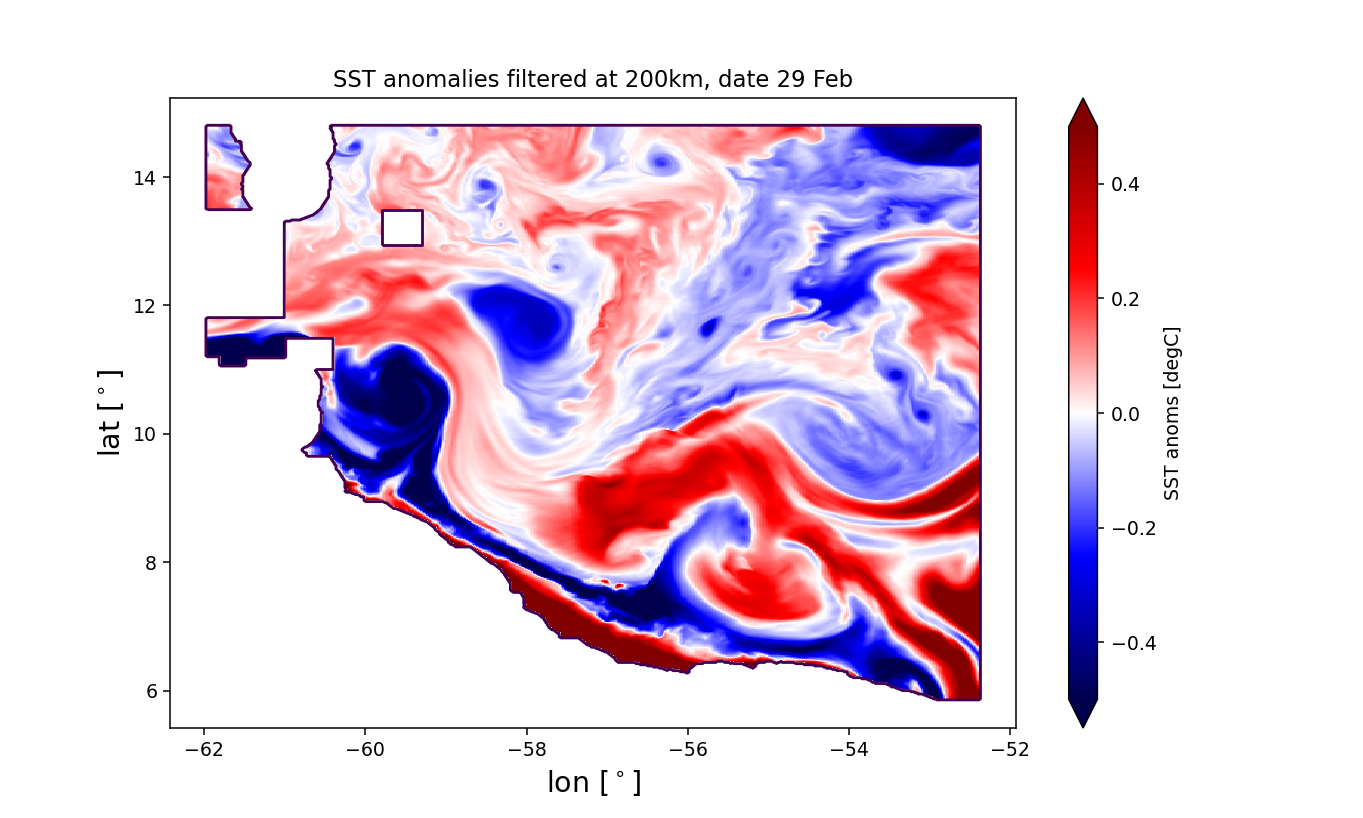

In [40]:
%matplotlib notebook

trange = 29                         #len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange))
# levs = [-0.6, -0.3, 0., 0.3, 0.5, 0.7]
mindsst, maxdsst = -0.5, 0.5
#cont_cmap = 'winter'
mesh_cmap = 'seismic'

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon_M[0,0], lon_M[0,-1]), ylim=(lat_M[0,0], lat_M[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# set initial plot
contf = ax.pcolormesh(lon_M, lat_M, dsst_day[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
cbar = fig.colorbar(contf, extend='both')
cbar.set_label('SST anoms [degC]')

cont = ax.contour(lon_M, lat_M, sea_mask, levels=[0.])  #, cmap=cont_cmap)  #dsst_day[0,:,:]

ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
ax.set_title(f'SST anomalies filtered at 200km, date {trange[0]+1} Feb')

# con_mask = ax.contourf(land_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)
con_mask = ax.contour(lon_M, lat_M, land_mask.values, levels=[1.])

# Animation function
def animate(i):
    ax.clear()     # clear previous plot
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'SST anomalies filtered at 200km, date {trange[i] + 1} Feb')

    contf = ax.pcolormesh(lon_M, lat_M, dsst_day[i,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
    cbar.update_normal(contf)
    #cbar.set_ticks(dsst_levs)
    #cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))

    cont = ax.contour(lon_M, lat_M, sea_mask, levels=[0.])

#     con_mask = ax.contourf(land_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)
    con_mask = ax.contour(lon_M, lat_M, land_mask.values, levels=[1.])
    
    
anima_dsst = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [41]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/home/alessandro/img_dottorato/dsst.gif', writer=writer)